In [1]:
import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

22/05/23 09:52:05 WARN Utils: Your hostname, Jesses-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.101 instead (on interface en0)
22/05/23 09:52:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/23 09:52:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/23 09:52:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


[wrangle.py] reading case.csv


[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features


[wrangle.py] joining departments



df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only show

Text(0, 0.5, 'Total Cases')

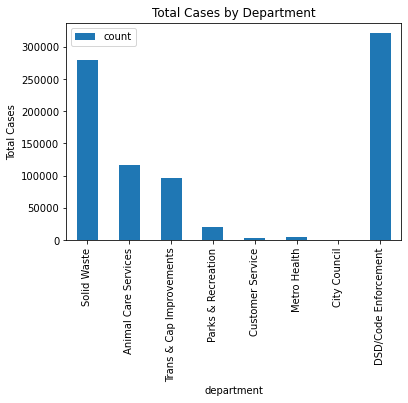

In [9]:
df.groupby("department").count().toPandas().set_index('department').plot.bar()
plt.title('Total Cases by Department')
plt.ylabel('Total Cases')


Does percentage of cases that are late vary by department?

In [57]:

late_by_department = df.groupby('department', 'case_late').count().toPandas().set_index('department')
# Get total cases per department
total_dept_case = late_by_department.groupby('department')['count'].sum()

late_by_department = late_by_department.assign(total_dept_case = total_dept_case)

late_by_department["percent_of_total"] = late_by_department['count']/late_by_department.total_dept_case

Text(0, 0.5, 'Percent Late')

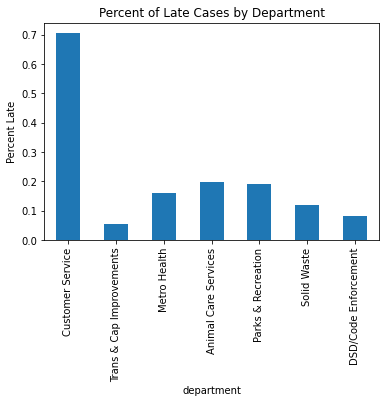

In [62]:
late_by_department[late_by_department.case_late]['percent_of_total'].plot.bar()
plt.title('Percent of Late Cases by Department')
plt.ylabel('Percent Late')

Yes, quite a large variation in percent of late cases by department

On average, how late are the late cases by department?

Text(0.5, 1.0, 'Average number of days late by department')

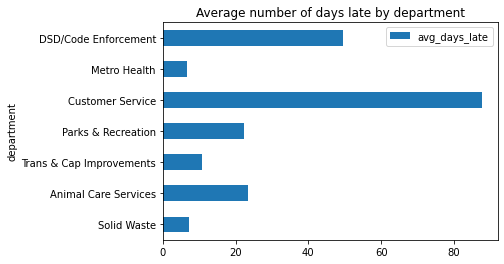

In [70]:
df.filter(df.case_late).groupby('department').agg(avg('num_days_late').alias('avg_days_late')).toPandas().set_index('department').plot.barh()
plt.title('Average number of days late by department')

What is the service type that is the most late? Just for Parks & Rec?

In [77]:
(
    df.filter(df.case_late)
    .groupby('service_request_type')
    .agg(avg('num_days_late')
    .alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .limit(1)
).show()

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Zoning: Recycle Yard|210.89201994318182|
+--------------------+------------------+



Just for parks and rec

In [79]:
(
    df.filter(df.case_late)
    .filter(df.department == 'Parks & Recreation')
    .groupby('service_request_type')
    .agg(avg('num_days_late')
    .alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .limit(1)
).show(truncate = False)

+------------------------+--------------+
|service_request_type    |avg_days_late |
+------------------------+--------------+
|Amenity Park Improvement|76.87018194568|
+------------------------+--------------+



For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [86]:
dept_st = df.groupby('department', 'service_request_type').count().toPandas()

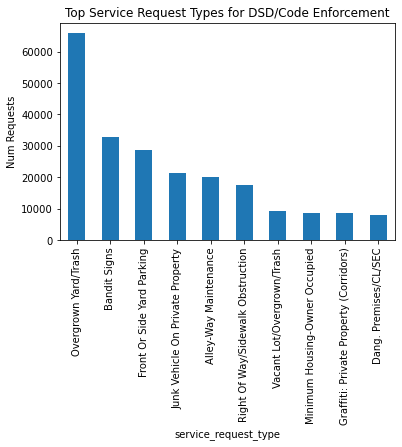

In [107]:
(dept_st[dept_st.department == 'DSD/Code Enforcement']
 .sort_values(by='count', ascending=False)[['service_request_type','count']]
 .head(10)
 .set_index('service_request_type')
 .plot.bar(legend = False))
plt.title('Top Service Request Types for DSD/Code Enforcement')
plt.ylabel('Num Requests')
None

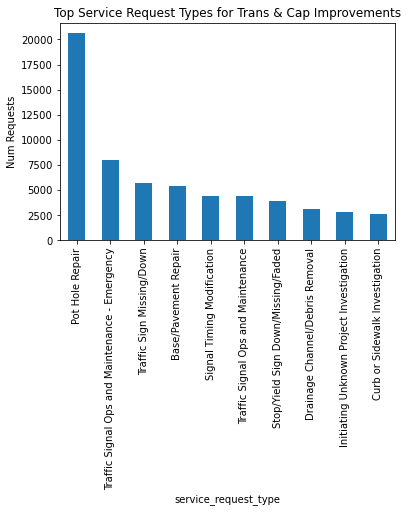

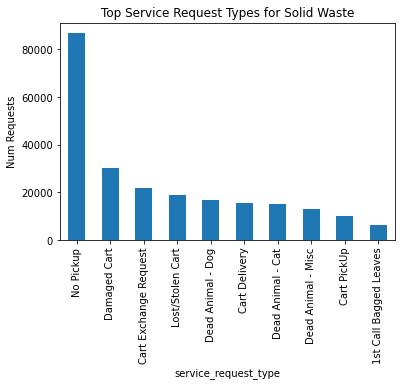

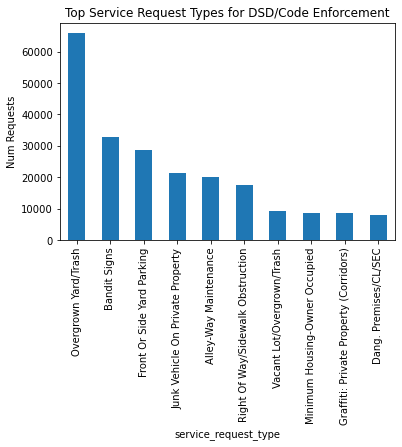

In [109]:
for dept in dept_st.department.unique()[:3]:

    (dept_st[dept_st.department == dept]
     .sort_values(by='count', ascending=False)[['service_request_type','count']]
     .head(10)
     .set_index('service_request_type')
     .plot.bar(legend = False))
    plt.title(f'Top Service Request Types for {dept}')
    plt.ylabel('Num Requests')
    plt.show()

Does whether or not its a weekend matter for when a case is opened/closed?

In [115]:
open_cases = df.groupby('case_opened_date').count().toPandas()
close_cases = df.groupby('case_closed_date').count().toPandas()

In [129]:
open_cases = open_cases.set_index(pd.to_datetime(open_cases.case_opened_date)).drop(['case_opened_date'], axis=1)

In [145]:
open_cases = open_cases.groupby(open_cases.index.day_name())['count'].sum()

In [146]:
# close_cases = close_cases.set_index(pd.to_datetime(close_cases.case_closed_date))
close_cases = close_cases.groupby(close_cases.index.day_name())['count'].sum()

Text(0.5, 1.0, 'Open and Close Cases by Day of Week\nFar fewer cases opened and closed on the weekend')

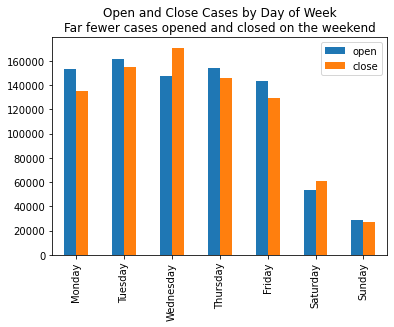

In [154]:
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
pd.DataFrame({'open':open_cases, 'close':close_cases}).loc[order].plot.bar()
plt.title('Open and Close Cases by Day of Week\nFar fewer cases opened and closed on the weekend')

On average, how many cases are opened a day for the Customer Service department?

In [163]:
df.filter(col('department') == 'Customer Service').groupby('case_opened_date').count().agg(avg('count').alias('avg_daily_cases_opened')).show()

+----------------------+
|avg_daily_cases_opened|
+----------------------+
|    1.0060028248587571|
+----------------------+



Does the number of service requests for the solid waste department vary by day of the week?

In [167]:
solid_waste = (
    df.filter(col('department') == 'Solid Waste')
    .groupby('case_opened_date')
    .count()
).toPandas()

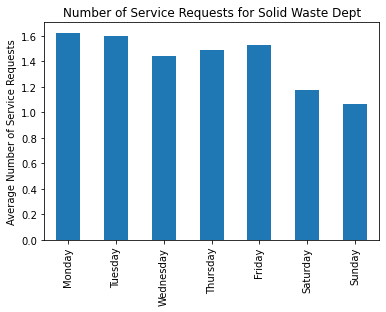

In [190]:
solid_waste.groupby(solid_waste.case_opened_date.dt.day_name())['count'].agg('mean').loc[order].plot.bar()
plt.title('Number of Service Requests for Solid Waste Dept')
plt.ylabel('Average Number of Service Requests')
plt.xlabel("")
None

Yes, there is some variability by day of the week